In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import seaborn as sns
from catboost import CatBoostRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from scipy import stats


In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('/test.csv')
submit = pd.read_csv('sample_submit.csv')

<h3> Part 2 (Optimisation of extra energy)

For this part it was decided to use scipy python library as the optimization algo can be regulated by using the number of max iterations. The number of iterations is directly affects the score very significantly. By using empirical method I found out that 100 iterations are the worst (its set as defult value). Tried to increase number of iterations to 150, 200, 250 I found out that best score lies between 200 and 250. So that's why 230 has been used. 

In [ ]:
from scipy.optimize import minimize

submit['pred'] = test_preds

def objective_function(allocated_energy, gain):
    return (gain* allocated_energy**2/1000).sum()*-1

def con_1st(allocated_energy):
    return np.sum(allocated_energy)*-1+50000

def con_2nd(allocated_energy):
    return np.sum(allocated_energy[:66])-5000

def function_of_increase(y):
    return -np.log(y+0.01)+3

con1 = {'type' : 'ineq', 'fun' : con_1st}
con2 = {'type' : 'ineq', 'fun' : con_2nd}
cons = [con1, con2]

x0 = 890 * [150]
b = (0.0, 100.0)
bnds = (b,) * 890
iters = 230

res = minimize(objective_function, x0, args = (function_of_increase(submit['pred'])), method = 'SLSQP', bounds = bnds, constraints = cons, options = {'maxiter' : iters})

In [ ]:
x = res.x
print(x.message)

In [ ]:
x

In [ ]:
submit['opt_pred'] = x
submit.to_csv('daniil_submit_best_score.csv', index = False)

<h3> Optimization using PuLp

I tried PuLp as well but it assigned either 100 or 0 to values which is true if we would have 100% sure predicted target. PuLp does not allow to regulate the number of iterations which is crucial for this task.

PuLp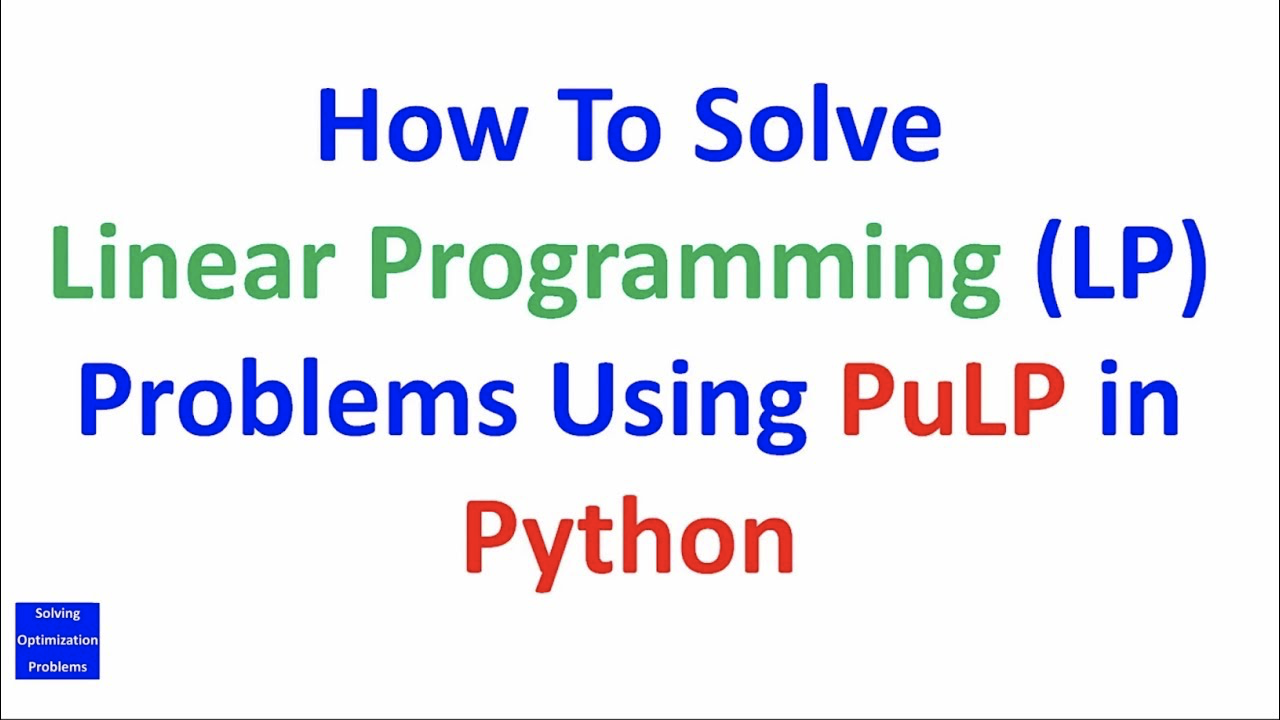

In [ ]:
!pip install pulp
from pulp import *

In [ ]:
# set up task
opt_model = LpProblem(name = "Energy allocation")

# set up names for vars
Energy_1 = ['' + str(i) for i in range(len(submit))]
Energy_2 = ['' + str(i) for i in range(66)]

# find potential for increase
submission['potential'] = (-np.log(submission.pred + 0.01) + 3)**2 / 1000
potential = list(submission.potential)
costs = dict(zip(Energy_1, potential))

# set up variables
ingredient_vars = LpVariable.dicts('energy', Energy_1, lowBound = 0, upBound = 100, cat = LpContinuous)

# objective function
opt_model += lpSum([costs[i]*ingredient_vars[i] for i in Energy_1])

# The two constraints are added to objective
opt_model += lpSum([ingredient_vars[i] for i in Energy_1]) <= 50000, 'Total sum'
opt_model += lpSum([ingredient_vars[i] for i in Energy_2]) >= 5000, 'Sum of the first 66 indexes'

# lp file
# opt_model.writeLP("EnergyAllocation.lp")

# for maximization
opt_model.sense = LpMaximize

# glpk solver
opt_model.solve(solver = GLPK_CMD())

opt_model.writeLP("EnergyAllocation_1.lp")


In [ ]:
print("Status:", LpStatus[opt_model.status])

In [ ]:
dictlist = []
for v in opt_model.variables():
    dictlist.append([v.name, v.varValue])

In [ ]:
data = pd.DataFrame(dictlist, columns = ['energy', 'value'])

In [ ]:
import re
data['energy'] = data['energy'].str.replace(r'\D', '')

In [ ]:
data.energy = data.energy.astype(int)

In [ ]:
data = data.sort_values('energy')
data

In [ ]:
submit['energy'] = data.value